In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [ ]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [ ]:
len(windmill)

In [ ]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [ ]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [ ]:
df = features.parallelize_extract(df)

In [ ]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [ ]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [ ]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [ ]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [ ]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [ ]:
len(df_train)

In [ ]:
df_train.to_parquet(constant.PH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PH_SC_EVL_path, index=False)

# Neural Network Train

In [6]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)

In [5]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=50
hidden_size = 1000
output_size = 1

## Original Features


In [6]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [7]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.027484996244311333 test loss: 0.02442103810608387
Epoch 10 train loss: 0.022928372025489807 test loss: 0.02175252139568329
Epoch 20 train loss: 0.021834801882505417 test loss: 0.02187882550060749
Epoch 30 train loss: 0.02100159041583538 test loss: 0.02253394015133381
Epoch 40 train loss: 0.020321141928434372 test loss: 0.023303158581256866
Epoch 49 train loss: 0.019551752135157585 test loss: 0.023786095902323723
Epoch 0 train loss: 0.02119205705821514 test loss: 0.008056310936808586
Epoch 10 train loss: 0.021437233313918114 test loss: 0.009266506880521774
Epoch 20 train loss: 0.02084105834364891 test loss: 0.008834233507514
Epoch 30 train loss: 0.02009936235845089 test loss: 0.00836150161921978
Epoch 40 train loss: 0.019360123202204704 test loss: 0.007927254773676395
Epoch 49 train loss: 0.01870661973953247 test loss: 0.007703925482928753
Epoch 0 train loss: 0.01831519417464733 test loss: 0.010292214341461658
Epoch 10 train loss: 0.01837713085114956 test loss: 0.0

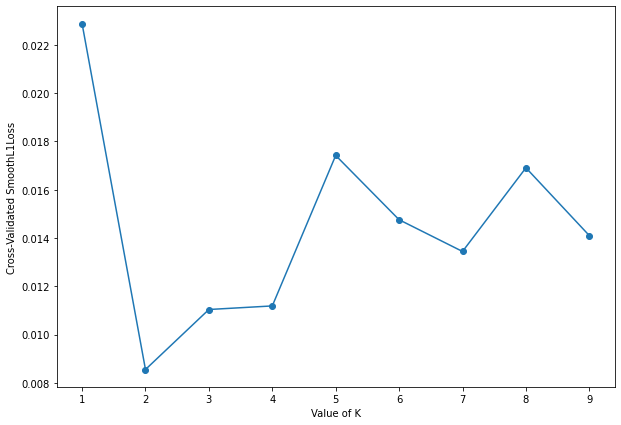

<Figure size 432x288 with 0 Axes>

In [8]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [9]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [10]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.010375802405178547
Epoch 10 train loss: 0.013716272078454494
Epoch 20 train loss: 0.01039549894630909
Epoch 30 train loss: 0.010655476711690426
Epoch 40 train loss: 0.01040002703666687


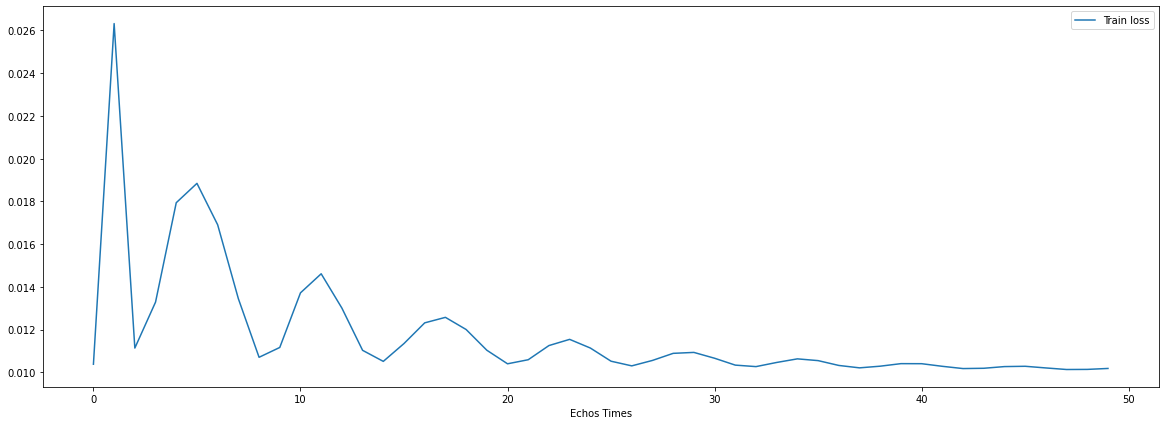

In [11]:
myplot.model_loss({"Train loss":train_hist_original}, path=path+"original_loss.png")

## Windshear Features

In [8]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [9]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.034577611833810806 test loss: 0.030857272446155548
Epoch 10 train loss: 0.014978887513279915 test loss: 0.015922218561172485
Epoch 20 train loss: 0.012943736277520657 test loss: 0.01466901320964098
Epoch 30 train loss: 0.012186538428068161 test loss: 0.013562117703258991
Epoch 40 train loss: 0.01190271321684122 test loss: 0.013339814729988575
Epoch 49 train loss: 0.011748422868549824 test loss: 0.013261009007692337
Epoch 0 train loss: 0.012493123300373554 test loss: 0.00634927861392498
Epoch 10 train loss: 0.012558764778077602 test loss: 0.006445599254220724
Epoch 20 train loss: 0.012149193324148655 test loss: 0.006273156963288784
Epoch 30 train loss: 0.011995677836239338 test loss: 0.006206265650689602
Epoch 40 train loss: 0.0118709160014987 test loss: 0.006135378032922745
Epoch 49 train loss: 0.011752106249332428 test loss: 0.006091265939176083
Epoch 0 train loss: 0.011562625877559185 test loss: 0.007695645559579134
Epoch 10 train loss: 0.011998300440609455 test

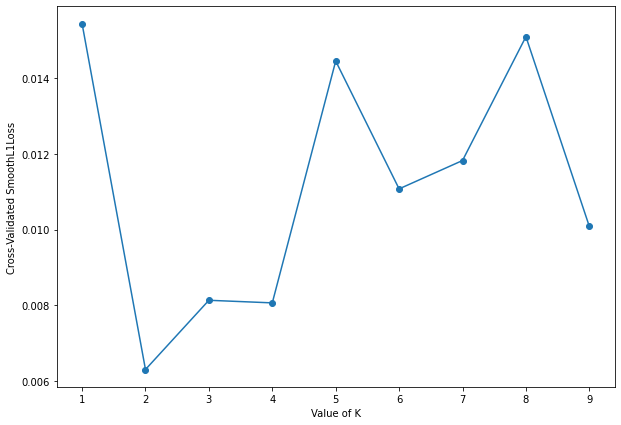

<Figure size 432x288 with 0 Axes>

In [10]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [11]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [12]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.01018152479082346
Epoch 10 train loss: 0.01145824696868658
Epoch 20 train loss: 0.010332099162042141
Epoch 30 train loss: 0.01010066643357277
Epoch 40 train loss: 0.01007222943007946


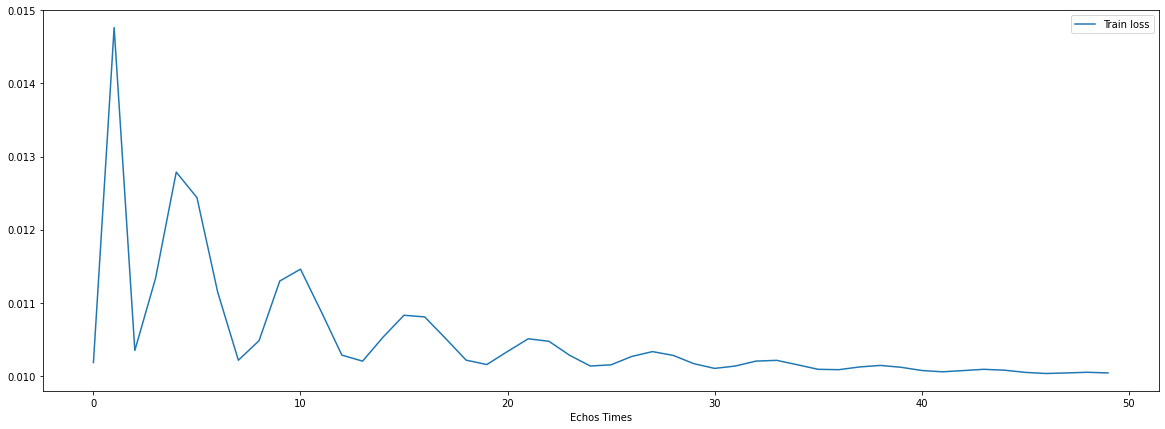

In [13]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [15]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [16]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03621024265885353 test loss: 0.03220082446932793
Epoch 10 train loss: 0.01184811070561409 test loss: 0.011590351350605488
Epoch 20 train loss: 0.009583883918821812 test loss: 0.010192318819463253
Epoch 30 train loss: 0.008935406804084778 test loss: 0.009258760139346123
Epoch 40 train loss: 0.008587900549173355 test loss: 0.008628802374005318
Epoch 49 train loss: 0.008492867462337017 test loss: 0.008484520949423313
Epoch 0 train loss: 0.008918103761970997 test loss: 0.004711658228188753
Epoch 10 train loss: 0.01070653647184372 test loss: 0.0061457715928554535
Epoch 20 train loss: 0.008843550458550453 test loss: 0.004689791705459356
Epoch 30 train loss: 0.008966557681560516 test loss: 0.00472692446783185
Epoch 40 train loss: 0.008848548866808414 test loss: 0.004658082965761423
Epoch 49 train loss: 0.00873156264424324 test loss: 0.0046065803617239
Epoch 0 train loss: 0.008570916019380093 test loss: 0.006187159568071365
Epoch 10 train loss: 0.010135983116924763 test l

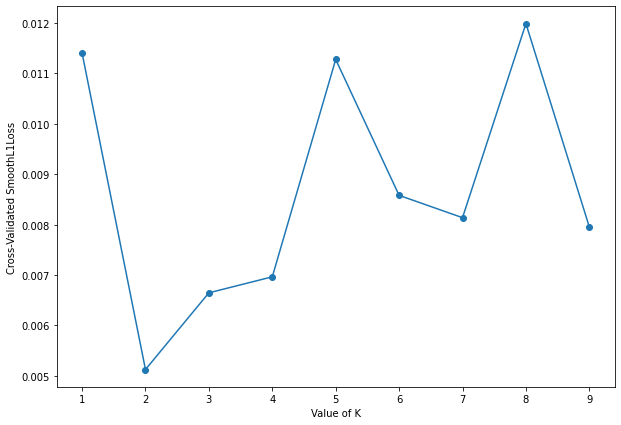

<Figure size 432x288 with 0 Axes>

In [17]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [18]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [19]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.007861238904297352
Epoch 10 train loss: 0.008808542042970657
Epoch 20 train loss: 0.0078835878521204
Epoch 30 train loss: 0.00787278637290001
Epoch 40 train loss: 0.007858077995479107


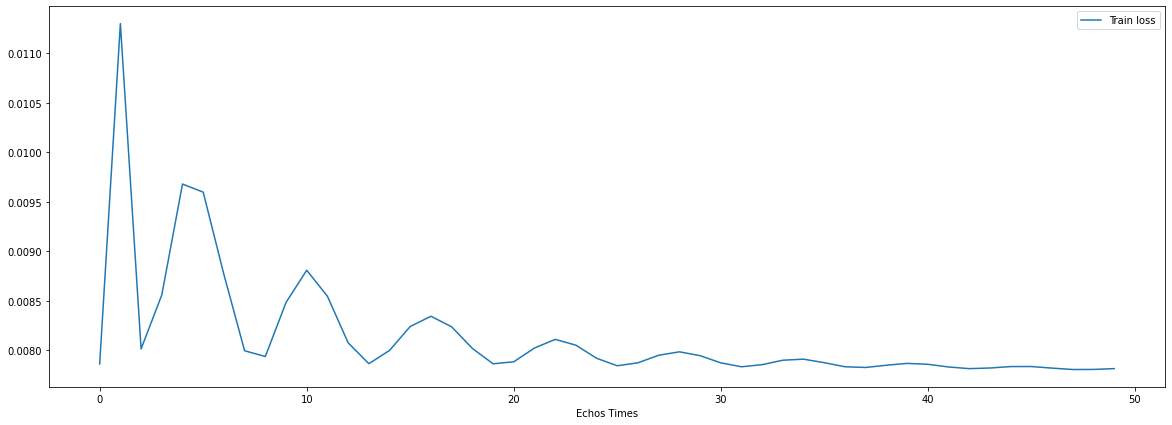

In [20]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [22]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=hidden_size
)

In [23]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03755345568060875 test loss: 0.03347611799836159
Epoch 10 train loss: 0.015000440180301666 test loss: 0.01582658663392067
Epoch 20 train loss: 0.012992043048143387 test loss: 0.014380230568349361
Epoch 30 train loss: 0.012332087382674217 test loss: 0.013298209756612778
Epoch 40 train loss: 0.011933119967579842 test loss: 0.013084671460092068
Epoch 49 train loss: 0.011726463213562965 test loss: 0.012969768606126308
Epoch 0 train loss: 0.012477091513574123 test loss: 0.006258916575461626
Epoch 10 train loss: 0.014241853728890419 test loss: 0.008272838778793812
Epoch 20 train loss: 0.012550284154713154 test loss: 0.006675263866782188
Epoch 30 train loss: 0.012195914052426815 test loss: 0.006194279529154301
Epoch 40 train loss: 0.012121709063649178 test loss: 0.0061308410950005054
Epoch 49 train loss: 0.012039178982377052 test loss: 0.006113721523433924
Epoch 0 train loss: 0.011803151108324528 test loss: 0.007939934730529785
Epoch 10 train loss: 0.013666626997292042 t

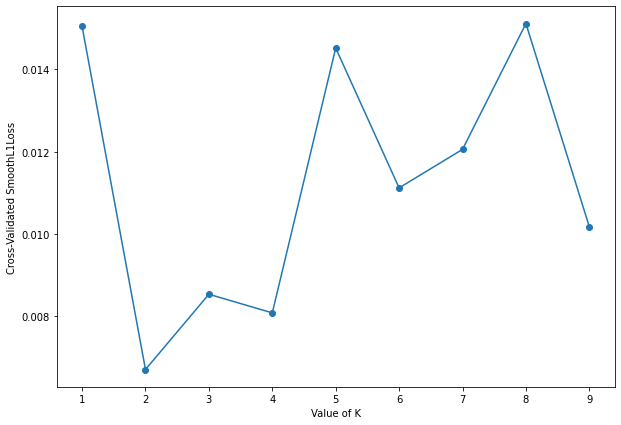

<Figure size 432x288 with 0 Axes>

In [24]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [25]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [26]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.010233686305582523
Epoch 10 train loss: 0.011527628637850285
Epoch 20 train loss: 0.010352140292525291
Epoch 30 train loss: 0.010155700147151947
Epoch 40 train loss: 0.010127846151590347


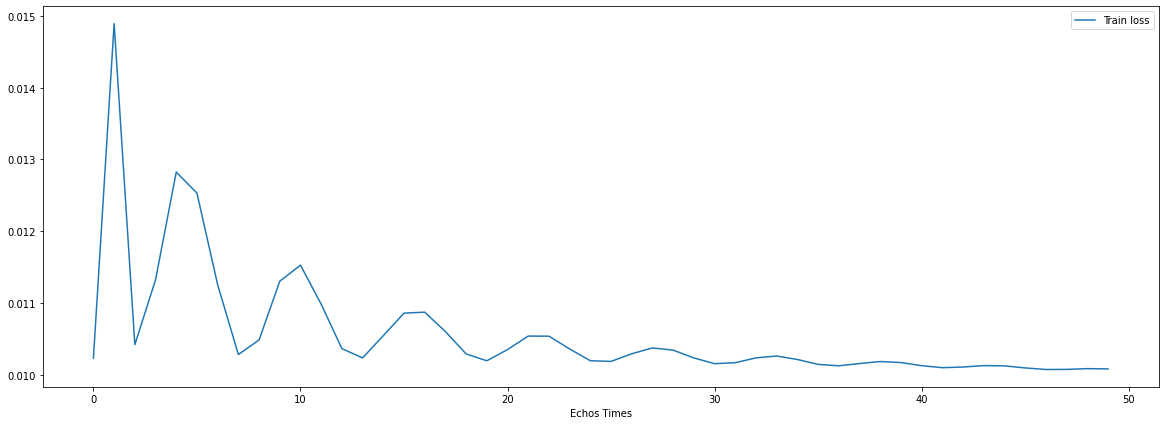

In [27]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")